In [47]:
import sys
import os
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import pandas as pd
import numpy as np
from glob import glob
from utils import *
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches

%matplotlib inline
cwd = os.getcwd()
input_dir = os.path.join(os.path.dirname(cwd), 'data', 'for_bb')
TARGET_WIDTH = 300
TARGET_HEIGHT = 268
img_shape=(3, 300, 268)
target_size = (300,268)

# Setup

In [7]:
ann = pd.read_csv('bbox_300_268_.csv')

In [8]:
input_dir

'/home/ubuntu/courses/deeplearning1/nbs/data/for_bb'

In [9]:
tr_b = ImageDataGenerator().flow_from_directory(input_dir+'/train',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 3862 images belonging to 1 classes.


In [10]:
val_b = ImageDataGenerator().flow_from_directory(input_dir+'/valid',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 682 images belonging to 1 classes.


In [11]:
tr_files = tr_b.filenames

In [12]:
val_files = val_b.filenames

In [13]:
tr_data = np.concatenate([tr_b.next() for i in range(tr_b.nb_sample)])

In [14]:
val_data = np.concatenate([val_b.next() for i in range(val_b.nb_sample)])

In [15]:
tr_data.shape

(3862, 3, 300, 268)

In [16]:
tr_files= [f[f.find('/')+1:] for f in tr_b.filenames]

In [17]:
val_files = [f[f.find('/')+1:] for f in val_b.filenames]

In [18]:
tr_ann = ann[ann.Image.isin(tr_files)]

In [19]:
val_ann = ann[ann.Image.isin(val_files)]

In [20]:
val_ann.head()

,Image,whaleID,height,width,image_width,image_height,bboxx,bboxy,filename,x_1,y_1,x_2,y_2,bboxx_new,bboxy_new,width_new,height_new
1,w_4598.jpg,whale_09913,478.725078,628.913338,3072,2048,1192.119312,1018.464137,w_4598.jpg,1639.625125,1212.873380,1353.762712,1265.962114,116.417902,133.275580,61.417318,62.645665
3,w_8734.jpg,whale_74162,356.471430,337.585527,3072,2048,1496.707861,984.427725,w_8734.jpg,1690.671984,1223.082752,1682.504487,1069.942173,146.162877,128.821597,32.967337,46.647629
4,w_3251.jpg,whale_99558,538.248253,439.097259,3072,2048,1406.999818,644.481460,w_3251.jpg,1655.960120,1071.984048,1662.085743,878.005982,137.402326,84.336441,42.880592,70.434830
7,w_825.jpg,whale_33152,545.330467,590.184488,3504,2336,1534.479668,864.030090,w_825.jpg,2033.228315,966.540379,1707.166500,1108.610169,131.376684,99.126740,50.529494,62.563598
11,w_3909.jpg,whale_06069,460.343900,632.677771,3072,2048,1397.556867,887.637469,w_3909.jpg,1925.487537,1157.742772,1678.420738,1031.146560,136.480163,116.155684,61.784939,60.240315


In [21]:
tr_y = []
for f in tr_files:
    r = tr_ann[tr_ann.Image == f]
    w = r.width_new.values[0]
    h = r.height_new.values[0]
    x = r.bboxx_new.values[0]
    y = r.bboxy_new.values[0]
    tr_y.append([w,h,x,y])

val_y = []
for f in val_files:
    r = val_ann[val_ann.Image == f]
    w = r.width_new.values[0]
    h = r.height_new.values[0]
    x = r.bboxx_new.values[0]
    y = r.bboxy_new.values[0]
    val_y.append([w,h,x,y])

tr_y = np.array(tr_y)

val_y = np.array(val_y)

In [25]:
def check_smaller(names, bboxes, sub_dir):
    idx = np.random.randint(0, high=len(names))
    print(idx)
    f = names[idx]
    bbox = bboxes[idx,:]    
    
    f_name =os.path.join(input_dir, sub_dir, 'wrap', f)
    img = Image.open(f_name)
    img_arr = np.array(img, dtype=np.uint8)

    # Create figure and axes
    fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(img_arr)
     # Create a Rectangle patch
    rect = patches.Rectangle((bbox[2],bbox[3] ),
                             bbox[0],
                             bbox[1], 
                             linewidth=1,
                             edgecolor='r',
                             facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)
    print(f)
    plt.show()



21
w_4162.jpg


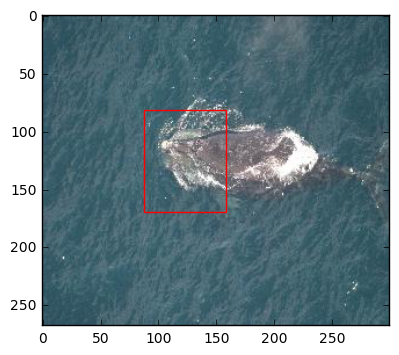

In [35]:
check_smaller(tr_files, tr_y, 'train')

281
w_6864.jpg


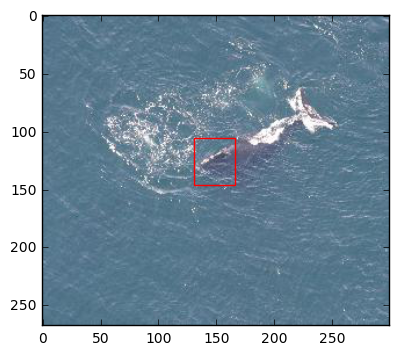

In [40]:
check_smaller(val_files, val_y, 'valid')

# Fit Model

In [41]:
tr_mean = np.mean(tr_data, axis=(0,2,3))

In [42]:
tr_mean.shape

(3,)

In [43]:
tr_mean.reshape((3,1,1))

array([[[  71.98833248]],

       [[  95.08053919]],

       [[ 108.27892684]]])

In [44]:
tr_mean_r = tr_mean.reshape((3,1,1))

In [50]:
def std(x): 
    x = x-tr_mean.reshape((3,1,1))
    return x

In [55]:
def get_model():
    return Sequential([
            Lambda(std, input_shape=img_shape),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(64, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(128, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            ZeroPadding2D((1, 1)),
            Convolution2D(256, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            ZeroPadding2D((1, 1)),
            Convolution2D(512, 3, 3, activation='relu'),
            MaxPooling2D((2, 2), strides=(2, 2)),
            BatchNormalization(),
            Flatten(),
            Dense(1024, activation='relu'),
            Dense(512, activation='relu'),
            Dense(4)
        ])

In [56]:
model = get_model()

In [57]:
model.compile(Adam(lr=0.001), loss='mean_squared_error', metrics=['accuracy'])

In [58]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=25)

Train on 3862 samples, validate on 682 samples
Epoch 1/25
3862/3862 [==============================] - 654s - loss: 993.9016 - acc: 0.6512 - val_loss: 1154.5772 - val_acc: 0.7405
Epoch 2/25
3862/3862 [==============================] - 654s - loss: 479.1319 - acc: 0.7543 - val_loss: 540.7527 - val_acc: 0.7903
Epoch 3/25
3862/3862 [==============================] - 654s - loss: 395.0816 - acc: 0.7913 - val_loss: 421.7732 - val_acc: 0.7903
Epoch 4/25
3862/3862 [==============================] - 654s - loss: 364.9412 - acc: 0.7965 - val_loss: 481.3452 - val_acc: 0.7258
Epoch 5/25
3862/3862 [==============================] - 654s - loss: 327.1424 - acc: 0.7947 - val_loss: 313.1418 - val_acc: 0.8006
Epoch 6/25


KeyboardInterrupt: 

In [59]:
model.save_weights('bb_reg_3.13.h5')

In [57]:
model.save_weights('whale_bb_129.h5')

In [56]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 106.7081 - acc: 0.8638 - val_loss: 131.0938 - val_acc: 0.8308
Epoch 2/10
4089/4089 [==============================] - 450s - loss: 105.2361 - acc: 0.8655 - val_loss: 124.7798 - val_acc: 0.8242
Epoch 3/10
4089/4089 [==============================] - 450s - loss: 92.5360 - acc: 0.8802 - val_loss: 185.1914 - val_acc: 0.8066
Epoch 4/10
4089/4089 [==============================] - 450s - loss: 86.2257 - acc: 0.8792 - val_loss: 148.2277 - val_acc: 0.8264
Epoch 5/10
4089/4089 [==============================] - 450s - loss: 80.8730 - acc: 0.8826 - val_loss: 129.3283 - val_acc: 0.8286
Epoch 6/10
 768/4089 [====>.........................] - ETA: 354s - loss: 71.0460 - acc: 0.8802

KeyboardInterrupt: 

In [59]:
model.save_weights('whale_bb_122.h5')

In [60]:
model.optimizer.lr = 0.0001

In [61]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 39.2634 - acc: 0.9171 - val_loss: 138.6453 - val_acc: 0.8286
Epoch 2/10
4089/4089 [==============================] - 449s - loss: 38.2008 - acc: 0.9156 - val_loss: 131.2853 - val_acc: 0.8418
Epoch 3/10
4089/4089 [==============================] - 449s - loss: 39.7533 - acc: 0.9235 - val_loss: 130.9264 - val_acc: 0.8374
Epoch 4/10
4089/4089 [==============================] - 451s - loss: 32.5617 - acc: 0.9254 - val_loss: 121.4119 - val_acc: 0.8396
Epoch 5/10
4089/4089 [==============================] - 451s - loss: 31.3996 - acc: 0.9269 - val_loss: 124.0389 - val_acc: 0.8352
Epoch 6/10
4089/4089 [==============================] - 450s - loss: 27.6569 - acc: 0.9337 - val_loss: 129.1431 - val_acc: 0.8571
Epoch 7/10
4089/4089 [==============================] - 450s - loss: 25.9184 - acc: 0.9354 - val_loss: 134.1947 - val_acc: 0.8022
Epoch 8/10
4089/4089 [=====================

In [62]:
model.optimizer.lr = 0.00001

In [63]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=10)

Train on 4089 samples, validate on 455 samples
Epoch 1/10
4089/4089 [==============================] - 450s - loss: 18.9432 - acc: 0.9445 - val_loss: 131.1113 - val_acc: 0.8440
Epoch 2/10
4089/4089 [==============================] - 450s - loss: 21.7494 - acc: 0.9401 - val_loss: 121.7423 - val_acc: 0.8418
Epoch 3/10
4089/4089 [==============================] - 449s - loss: 17.3245 - acc: 0.9469 - val_loss: 127.7389 - val_acc: 0.8484
Epoch 4/10
4089/4089 [==============================] - 450s - loss: 15.2120 - acc: 0.9411 - val_loss: 113.5965 - val_acc: 0.8484
Epoch 5/10
4089/4089 [==============================] - 450s - loss: 17.6442 - acc: 0.9411 - val_loss: 122.0209 - val_acc: 0.8374
Epoch 6/10
4089/4089 [==============================] - 451s - loss: 16.8782 - acc: 0.9533 - val_loss: 119.5340 - val_acc: 0.8330
Epoch 7/10
4089/4089 [==============================] - 450s - loss: 15.4750 - acc: 0.9467 - val_loss: 124.3540 - val_acc: 0.8396
Epoch 8/10
4089/4089 [=====================

KeyboardInterrupt: 

In [65]:
model.optimizer.lr = 0.000001

In [66]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=1)

Train on 4089 samples, validate on 455 samples
Epoch 1/1
4089/4089 [==============================] - 450s - loss: 13.0874 - acc: 0.9552 - val_loss: 116.9361 - val_acc: 0.8374


In [67]:
model.save_weights('116.9.h5')

In [68]:
model.fit(tr_data, tr_y, validation_data=(val_data, val_y), shuffle=True, nb_epoch=1)

Train on 4089 samples, validate on 455 samples
Epoch 1/1
4089/4089 [==============================] - 450s - loss: 13.6130 - acc: 0.9579 - val_loss: 131.2703 - val_acc: 0.8220


In [69]:
model.load_weights('116.9.h5')

In [70]:
preds = model.predict(val_data)

50
w_5616.jpg


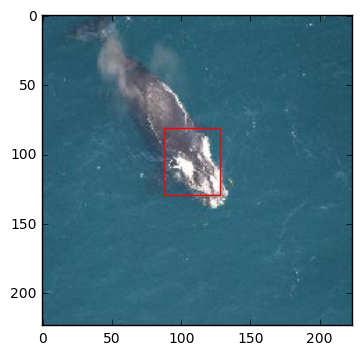

In [90]:
check_smaller(val_files, preds)

# Step forward. Get predictions on test set.

In [91]:
test_b = ImageDataGenerator().flow_from_directory(img_dir+'/test',
                                                shuffle=False, 
                                                target_size=target_size, 
                                                batch_size=1,
                                               class_mode=None)

Found 6925 images belonging to 1 classes.


In [92]:
test_files = test_b.filenames

In [93]:
save_array('test_file_names.bc', test_files)

In [94]:
test_data = np.concatenate([test_b.next() for i in range(test_b.nb_sample)])

In [95]:
save_array('test_data_224_224.bc', test_data)

In [96]:
test_preds = model.predict(test_data)

In [99]:
test_files = [f[f.find('/')+1:] for f in test_files]

821
w_2771.jpg


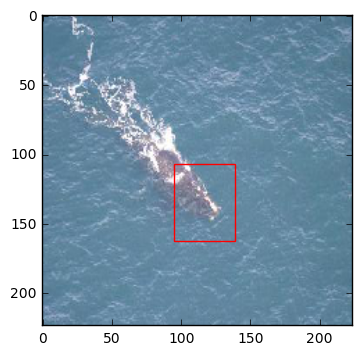

In [124]:
check_smaller(test_files, test_preds)

In [125]:
test_ann = pd.DataFrame(np.hstack((np.array(test_files)[:, np.newaxis], test_preds)), columns=['Image', 'width', 'height', 'x', 'y'])

In [126]:
test_ann.head()

,Image,width,height,x,y
0,w_8037.jpg,29.0913066864,50.4047203064,90.4007720947,98.9544677734
1,w_4494.jpg,32.1990737915,45.0582427979,84.8776702881,57.4592323303
2,w_4673.jpg,44.787689209,54.903339386,103.601135254,91.891708374
3,w_8273.jpg,41.8063430786,50.1853218079,100.628494263,60.9373054504
4,w_7611.jpg,37.7578010559,57.7667121887,120.307563782,76.0566101074


In [128]:
test_ann.to_csv('test_ann.csv', index=False)